## **Интерпретация прогнозов модели (SHAP)**

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для: всего тестового набора данных (summary_plot - дать интерпретацию), для топ 10%
6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат 

In [3]:
!pip install shap

     |████████████████████████████████| 371 kB 34.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509235 sha256=bd963ff0226858d9a1abbbe580a0ef3c37692c220e6f1a9e2bf2597dd543218f
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
%matplotlib inline

Загрузка данных

https://archive.ics.uci.edu/ml/datasets/Adult

In [18]:
df = pd.read_csv('/content/drive/MyDrive/adult.data', header=None, names=['age', 'workclass', 'fnlwgt', 'education', 
                                                                  'education-num', 'marital-status', 'occupation', 
                                                                  'relationship', 'race', 'sex', 'capital-gain', 
                                                                  'capital-loss', 'hours-per-week', 'native-country', 'income'])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Преобразование целевой переменной к числовому виду

In [19]:
df['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [20]:
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1}) 
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Проверка наличия пропусков

In [21]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Разбиение данных на test и train

In [31]:
X = df.copy()
X.drop(columns='income', inplace=True)
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, df['income'], test_size=0.3, shuffle=True, stratify=df['income'], random_state=42)

Построение модели

In [41]:
XB = xgb.train({"learning_rate": 0.3},xgb.DMatrix(X_train, label=y_train),100)
y_pred = XB.predict(xgb.DMatrix(X_test, label=y_test))

Расчёт метрик

In [42]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix], 
                                                                                      fscore[ix],
                                                                                      precision[ix],
                                                                                      recall[ix],
                                                                                     roc_auc_score(y_test, y_pred)))

Best Threshold=0.403686, F-Score=0.736, Precision=0.720, Recall=0.753, ROC_AUC=0.925


Построение важности признаков для тестового набора данных

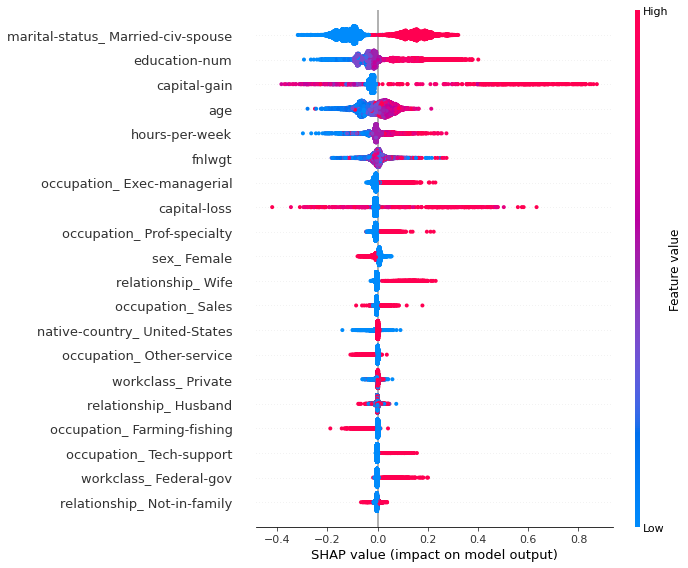

In [45]:
explainer = shap.TreeExplainer(XB)
shap_values_test = explainer.shap_values(X_test)
shap.summary_plot(shap_values_test, X_test)

**Выводы:**<br>
1) Молодые люди зарабатывают меньше (признак age)<br>
2) Женатые люди зарабатывают больше неженатых (признак married)<br>
3) Люди, которые долго учились зарабатывают больше (признак education-num)<br>
4) Люди, работающие дольше, получают больше (hours-per-week)<br>
5) Женщины зарабатывают меньше мужчин (признак sex_Female)<br>



Построение важности признаков для топ 10%

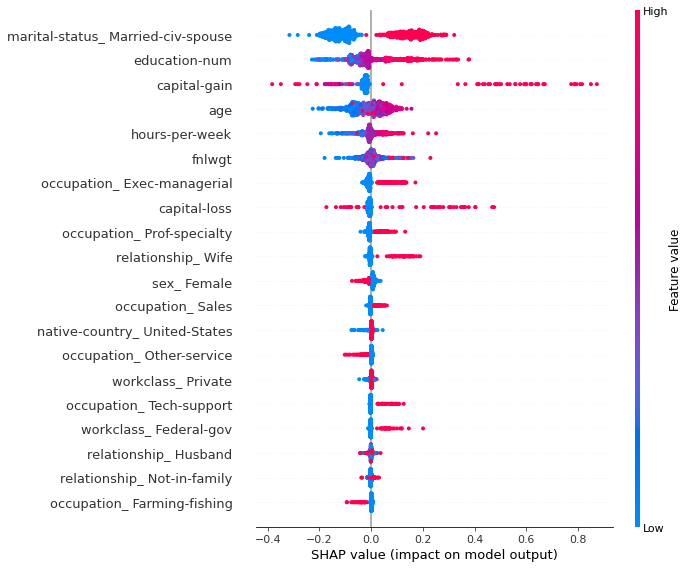

In [52]:
X_test_top10 = X_test.iloc[:int(X_test.shape[0] * .1)]
shap_values_test_top10 = explainer.shap_values(X_test_top10)
shap.summary_plot(shap_values_test_top10, X_test_top10)

force_plot для трёх случайных наблюдений

In [54]:
random_indexes = [np.random.randint(0, int(X_test.shape[0])) for x in range(3)]
random_indexes

[2710, 7432, 2459]

In [55]:
shap.force_plot(explainer.expected_value, shap_values_test[random_indexes[0],:], X_test.iloc[random_indexes[0],:])